# 1. Повнозв'язані нейронні мережі
# Вирішіть завдання класифікації даних, з якими ви працювали в лабораторній № 1 за допомогою повнозв’язаної нейромережі прямого поширення (fully connected feed-forward network). Результати порівняйте з одержаними раніше. 

In [1]:
!pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

df = pd.read_csv("Life Expectancy Data.csv")

from sklearn.impute import SimpleImputer
imputer=SimpleImputer(missing_values=np.nan,strategy='mean',fill_value=None)
df_nan = df.isnull().sum()
list_col_to_fill = list(df_nan[df_nan > 0].index)
for cl_n in list_col_to_fill:
    df[cl_n] = imputer.fit_transform(df[[cl_n]])
    
def classify_life_expectancy(value):
    if value < 60:
        return 0  # Низька
    elif 60 <= value <= 75:
        return 1  # Середня
    else:
        return 2  # Висока
X = df.drop(columns=["Life expectancy "])
df['Life expectancy class'] = df['Life expectancy '].apply(classify_life_expectancy)
y = df['Life expectancy class']


from sklearn.preprocessing import StandardScaler
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns


scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
categorical_columns = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
X['Status_Developing'] = X['Status_Developing'].astype(int)
for col_ in X.columns:
    if "Country_" in col_:
        X[col_] = X[col_].astype(int)
    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train.values, dtype=torch.float32)  
X_test = torch.tensor(X_test.values, dtype=torch.float32)   
y_train = torch.tensor(y_train.values, dtype=torch.long)  
y_test = torch.tensor(y_test.values, dtype=torch.long)

Типи даних:
 Country                             object
Year                               float64
Status                              object
Adult Mortality                    float64
infant deaths                      float64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                            float64
 BMI                               float64
under-five deaths                  float64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object
Категоріальні колонки:
 Index(['Country', 'Status'], dtype='object')
Р

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)  
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


num_classes = 3  
input_dim = X_train.shape[1]
model = FeedForwardNN(input_dim, num_classes)

criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [3]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    y_pred = model(X_train)  
    loss = criterion(y_pred, y_train)  
    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step()  

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 10/100, Loss: 0.4362
Epoch 20/100, Loss: 0.1993
Epoch 30/100, Loss: 0.1280
Epoch 40/100, Loss: 0.0900
Epoch 50/100, Loss: 0.0650
Epoch 60/100, Loss: 0.0473
Epoch 70/100, Loss: 0.0338
Epoch 80/100, Loss: 0.0251
Epoch 90/100, Loss: 0.0190
Epoch 100/100, Loss: 0.0160


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       119
           1       0.95      0.94      0.95       304
           2       0.92      0.95      0.93       165

    accuracy                           0.94       588
   macro avg       0.94      0.94      0.94       588
weighted avg       0.94      0.94      0.94       588

Confusion Matrix:
[[113   5   1]
 [  6 285  13]
 [  0   9 156]]


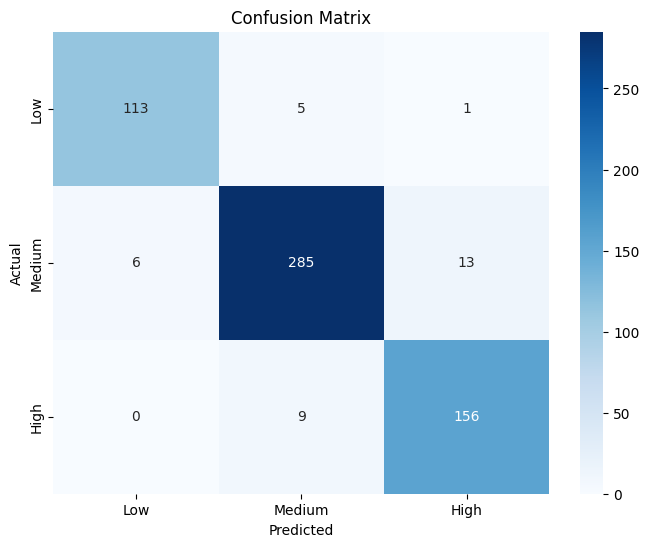

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_classes = torch.argmax(y_pred_test, axis=1) 

print("Classification Report:")
print(classification_report(y_test, y_pred_classes.numpy()))

conf_matrix = confusion_matrix(y_test, y_pred_classes.numpy())
print("Confusion Matrix:")
print(conf_matrix)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Модель не змогла досягти кращих результатів за Random Forest, але це бейзлайн-архітектура і вона має високі скори, тож я вважаю що є всі шанси покращити результати моделі.

# 2. Згорткові нейронні мережі
# Вирішіть завдання класифікації зображень за допомогою згорткової (convolutional) нейромережі двома способами
# а) навчить мережу з нуля (from scratch)
# б) застосуйте перенесення навчання (transfer learning from pre-trained weights)
# Порівняйте результати (якщо в обраному датасеті класів забагато, достатньо залишити 3-5).

In [5]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os


data_path = "tom_and_jerry_dataset"


transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])


dataset = ImageFolder(root=data_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(dataset.classes)

Класи в датасеті: ['jerry', 'tom']
Кількість класів: 2, Класи: ['jerry', 'tom']


In [10]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
from torchvision.models import resnet18

model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy (no transfer learning): {accuracy:.4f}')

Epoch 1/15, Loss: 0.4562
Epoch 2/15, Loss: 0.6791
Epoch 3/15, Loss: 0.5906
Epoch 4/15, Loss: 0.5153
Epoch 5/15, Loss: 0.5669
Epoch 6/15, Loss: 0.6423
Epoch 7/15, Loss: 0.7108
Epoch 8/15, Loss: 0.5657
Epoch 9/15, Loss: 0.5100
Epoch 10/15, Loss: 0.4681
Epoch 11/15, Loss: 0.6296
Epoch 12/15, Loss: 0.6141
Epoch 13/15, Loss: 0.5871
Epoch 14/15, Loss: 0.7318
Epoch 15/15, Loss: 0.5402
Accuracy (transfer learning): 0.7603


In [13]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

C:\Users\v1415\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\v1415\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

    
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy (transfer learning): {accuracy:.4f}')


Epoch 1/15, Loss: 0.9797
Epoch 2/15, Loss: 0.2351
Epoch 3/15, Loss: 0.3806
Epoch 4/15, Loss: 0.4576
Epoch 5/15, Loss: 0.1862
Epoch 6/15, Loss: 0.0983
Epoch 7/15, Loss: 0.2914
Epoch 8/15, Loss: 0.4375
Epoch 9/15, Loss: 0.3404
Epoch 10/15, Loss: 0.2335
Epoch 11/15, Loss: 0.7845
Epoch 12/15, Loss: 0.4143
Epoch 13/15, Loss: 0.1174
Epoch 14/15, Loss: 0.3294
Epoch 15/15, Loss: 0.7931
Accuracy (transfer learning): 0.8738


Претрейн досяг кращих результатів за однаковий проміжок часу.

# 3. Рекурентні нейронні мережі
# Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі двома способами:
# а) навчить мережу і embedding шар з нуля (from scratch)
# б) використовуючи pretrained word embeddings
#  Результати порівняйте між собою і з одержаними раніш. 

In [15]:
import os
import pandas as pd


dataset_path = r"review_polarity\txt_sentoken"


pos_reviews = []
neg_reviews = []


for filename in os.listdir(os.path.join(dataset_path, "pos")):
    with open(os.path.join(dataset_path, "pos", filename), "r", encoding="utf-8") as file:
        pos_reviews.append(file.read())

        
for filename in os.listdir(os.path.join(dataset_path, "neg")):
    with open(os.path.join(dataset_path, "neg", filename), "r", encoding="utf-8") as file:
        neg_reviews.append(file.read())

        
reviews = pos_reviews + neg_reviews
labels = ["positive"] * len(pos_reviews) + ["negative"] * len(neg_reviews)

df = pd.DataFrame({"review": reviews, "sentiment": labels})
print(df.head())

                                              review sentiment
0  films adapted from comic books have had plenty...  positive
1  every now and then a movie comes along from a ...  positive
2  you've got mail works alot better than it dese...  positive
3   " jaws " is a rare film that grabs your atten...  positive
4  moviemaking is a lot like being the general ma...  positive


In [37]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')


df['tokens'] = df['review'].apply(word_tokenize)


word_counter = Counter(token for tokens in df['tokens'] for token in tokens)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counter.most_common(5000))}
vocab['<pad>'] = 0
vocab['<unk>'] = 1


def text_pipeline(tokens):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

df['encoded'] = df['tokens'].apply(text_pipeline)


labels = {'positive': 1, 'negative': 0}
df['label'] = df['sentiment'].map(labels)


train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\v1415\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data.iloc[idx]['encoded']
        label = self.data.iloc[idx]['label']
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    
def collate_batch(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return texts, labels


train_dataset = TextDataset(train_data)
test_dataset = TextDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_batch)


In [39]:
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        output = self.fc(hidden.squeeze(0))
        return output

    
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 128
num_classes = 2  # positive, negative

model = RNNModel(vocab_size, embed_dim, hidden_dim, num_classes)


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}')


Epoch 1/10, Loss: 34.5570
Epoch 2/10, Loss: 34.3653
Epoch 3/10, Loss: 34.1186
Epoch 4/10, Loss: 34.1095
Epoch 5/10, Loss: 33.8609
Epoch 6/10, Loss: 34.1312
Epoch 7/10, Loss: 33.8413
Epoch 8/10, Loss: 33.8160
Epoch 9/10, Loss: 33.7512
Epoch 10/10, Loss: 33.6553


In [44]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        predictions = torch.argmax(outputs, dim=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.numpy())


print("Classification Report:")
print(classification_report(y_true, y_pred))


print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.98      0.66       201
           1       0.55      0.03      0.06       199

    accuracy                           0.51       400
   macro avg       0.52      0.50      0.36       400
weighted avg       0.52      0.51      0.36       400

Confusion Matrix:
[[196   5]
 [193   6]]


In [45]:
from gensim.models import KeyedVectors

glove_path = 'glove.6B.100d.txt'
glove = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

embedding_matrix = np.zeros((vocab_size, 100))
for word, idx in vocab.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]

model.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)


In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}')


Epoch 1/10, Loss: 38.5575
Epoch 2/10, Loss: 34.7189
Epoch 3/10, Loss: 34.5753
Epoch 4/10, Loss: 34.6298
Epoch 5/10, Loss: 34.6231
Epoch 6/10, Loss: 34.6416
Epoch 7/10, Loss: 34.6737
Epoch 8/10, Loss: 34.5805
Epoch 9/10, Loss: 34.6646
Epoch 10/10, Loss: 34.5415


In [47]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        predictions = torch.argmax(outputs, dim=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       201
           1       0.67      0.05      0.09       199

    accuracy                           0.52       400
   macro avg       0.59      0.51      0.38       400
weighted avg       0.59      0.52      0.38       400

Confusion Matrix:
[[196   5]
 [189  10]]


З претрейном у виді Glove точність покращилась